In [18]:
import os
import numpy as np
import pandas as pd
import joblib as jl
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
data = pd.read_csv('DummiesV2.csv')

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
targets = ['Indemne', 'Blessé léger', 'Blessé hospitalisé', 'Tué']
X = data.drop(targets, axis=1)
X = pd.DataFrame(data=StandardScaler().fit_transform(X), columns=X.columns)
Y = data[targets].values.argmax(axis=1) # cela réordonne bien les modalités puisque `targets` est ordonnée.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)

In [21]:
def plot_confusion_matrix(matrix, classes,
                          normalize=False,
                          cmap=plt.cm.Blues,
                          title=None):

    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        title = title if title else "Normalized confusion matrix"
    else:
        title = title if title else "Raw confusion matrix"

    sns.set_style('ticks')
    res = sns.heatmap(matrix,
                      cmap=cmap,
                      cbar=True,
                      square=True,
                      annot=True)

    for _, spine in res.spines.items():
        spine.set_visible(True)

    plt.title(title)
    tick_marks = np.arange(len(classes)) + .5
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=0)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Avec une régression logistique

### Non-équilibrée

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

retrain = False
if not os.path.isfile('regression-log-unbalanced.joblib') or retrain:
    ULR = LogisticRegression(multi_class='multinomial', max_iter=1000)
    selector_ULR = RFECV(ULR, cv=StratifiedKFold(2), scoring="accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_ULR, 'regression-log-unbalanced.joblib')
else:
    selector_ULR = jl.load('regression-log-unbalanced.joblib')

ULR = selector_ULR.estimator_

In [23]:
selected_ULR = [variable for variable, boolean in zip(X.columns.tolist(), selector_ULR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(ULR.predict(X_test[selected_ULR]) == Y_test))

Accuracy : 0.6493888637392485


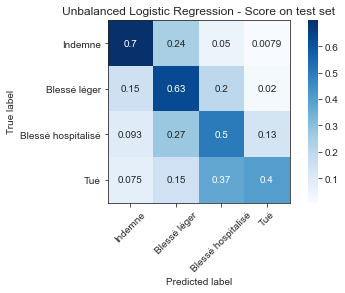

In [24]:
from sklearn import metrics
conf = metrics.confusion_matrix(ULR.predict(X_test[selected_ULR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Logistic Regression - Score on test set');

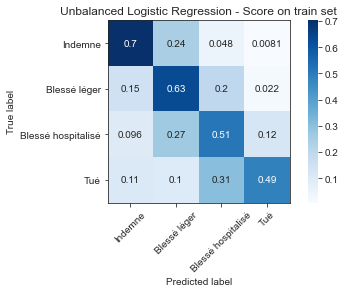

In [25]:
conf = metrics.confusion_matrix(ULR.predict(X_train[selected_ULR]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Logistic Regression - Score on train set');

### Equilibrée

In [26]:
retrain = False
if not os.path.isfile('regression-log-balanced.joblib') or retrain:
    BLR = LogisticRegression(multi_class='multinomial', max_iter=1000, class_weight='balanced')
    selector_BLR = RFECV(BLR, cv=StratifiedKFold(2), scoring="balanced_accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_BLR, 'regression-log-balanced.joblib')
else:
    selector_BLR = jl.load('regression-log-balanced.joblib')

BLR = selector_BLR.estimator_

In [27]:
selected_BLR = [variable for variable, boolean in zip(X.columns.tolist(), selector_BLR.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BLR.predict(X_test[selected_BLR]) == Y_test))

Accuracy : 0.5832453095920729


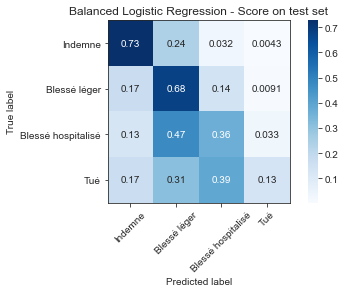

In [28]:
conf = metrics.confusion_matrix(BLR.predict(X_test[selected_BLR]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Logistic Regression - Score on test set');

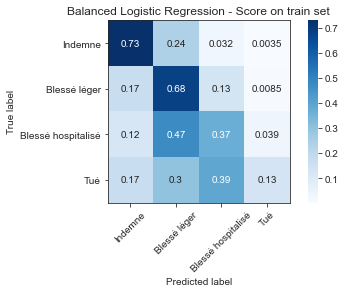

In [29]:
conf = metrics.confusion_matrix(BLR.predict(X_train[selected_BLR]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Logistic Regression - Score on train set');

# Avec un Random Forest

### Non-équilibré

In [30]:
from sklearn.ensemble import RandomForestClassifier

retrain = False
if not os.path.isfile('randomforest-unbalanced.joblib') or retrain:
    URF = RandomForestClassifier()
    selector_URF = RFECV(URF, cv=StratifiedKFold(2), scoring="accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_URF, 'randomforest-unbalanced.joblib')
else:
    selector_URF = jl.load('randomforest-unbalanced.joblib')

URF = selector_URF.estimator_

In [31]:
selected_URF = [variable for variable, boolean in zip(X.columns.tolist(), selector_URF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(URF.predict(X_test[selected_URF]) == Y_test))

Accuracy : 0.6550726824606408


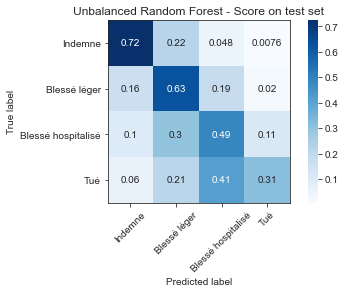

In [32]:
conf = metrics.confusion_matrix(URF.predict(X_test[selected_URF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Random Forest - Score on test set');

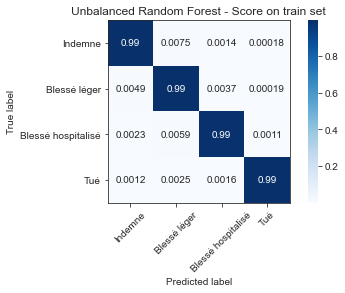

In [33]:
conf = metrics.confusion_matrix(URF.predict(X_train[selected_URF]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Unbalanced Random Forest - Score on train set');

### Equilibré

In [34]:
retrain = False
if not os.path.isfile('randomforest-balanced.joblib') or retrain:
    BRF = RandomForestClassifier(class_weight='balanced')
    selector_BRF = RFECV(BRF, cv=StratifiedKFold(2), scoring="accuracy", step=1, verbose=4).fit(X_train, Y_train)
    jl.dump(selector_BRF, 'randomforest-balanced.joblib')
else:
    selector_BRF = jl.load('randomforest-balanced.joblib')

BRF = selector_BRF.estimator_

In [35]:
selected_BRF = [variable for variable, boolean in zip(X.columns.tolist(), selector_BRF.support_.tolist()) if boolean]
print('Accuracy :', np.mean(BRF.predict(X_test[selected_BRF]) == Y_test))

Accuracy : 0.6555756752678437


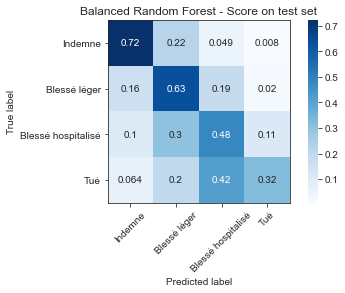

In [36]:
conf = metrics.confusion_matrix(BRF.predict(X_test[selected_BRF]), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Random Forest - Score on test set');

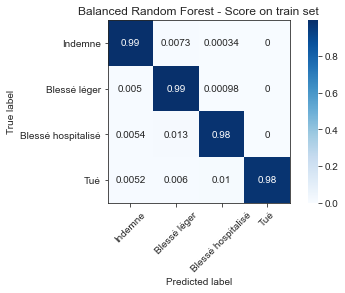

In [37]:
conf = metrics.confusion_matrix(BRF.predict(X_train[selected_BRF]), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Balanced Random Forest - Score on train set');

### Optimisation des hyperparamètres

In [38]:
X_train_RF = X_train[selected_BRF]
X_test_RF = X_test[selected_BRF]

In [54]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

retrain = False
if not os.path.isfile('randomforest-optimized.joblib') or retrain:
    rfc = RandomForestClassifier(class_weight='balanced')
    parameters = {'max_depth': np.logspace(0,2,10).astype(int),
                  'criterion': ['gini', 'entropy'],
                  'min_samples_leaf': [1],
                  'max_features': ['sqrt, log2'],
                  'n_estimators': [100]}
    cv_res = GridSearchCV(rfc, parameters, cv=StratifiedKFold(5), scoring='accuracy', verbose=4).fit(X_train_RF, Y_train)
    #jl.dump(cv_res, 'randomforest-optimized.joblib')
else:
    cv_res = jl.load('randomforest-optimized.joblib')
    
ORF = cv_res.best_estimator_
scores = pd.DataFrame(cv_res.cv_results_)
ORF.get_params()



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 35,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

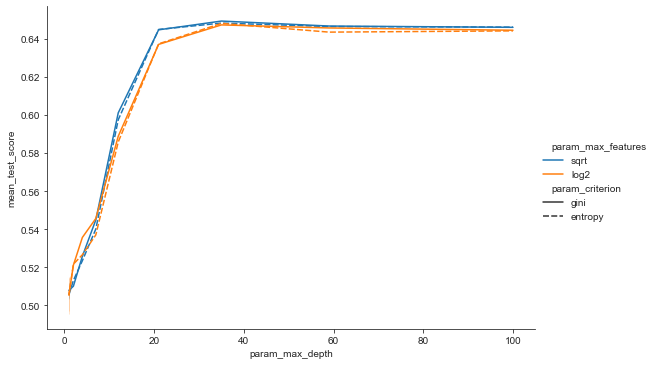

In [56]:
sns.relplot(data=scores, kind='line', x='param_max_depth', y='mean_test_score',
            style='param_criterion', hue='param_max_features', aspect=1.5);

Accuracy on test set : 0.6605050047784317


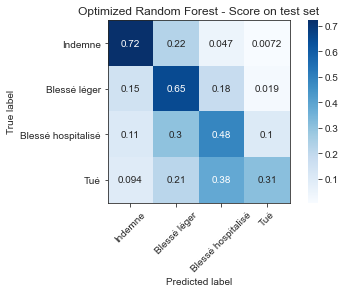

In [57]:
print('Accuracy on test set :', np.mean(ORF.predict(X_test_RF) == Y_test))
conf = metrics.confusion_matrix(ORF.predict(X_test_RF), Y_test)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Optimized Random Forest - Score on test set');

Accuracy on train set : 0.9730854217192132


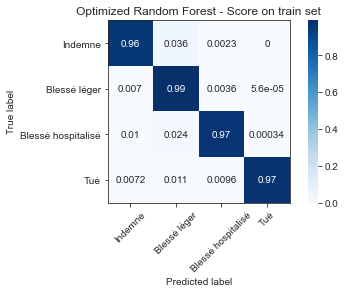

In [58]:
print('Accuracy on train set :', np.mean(ORF.predict(X_train_RF) == Y_train))
conf = metrics.confusion_matrix(ORF.predict(X_train_RF), Y_train)
plot_confusion_matrix(conf, classes=targets, normalize=True, title='Optimized Random Forest - Score on train set');

# Variables éliminées par les différents modèles

### Par la régression linéaire

In [43]:
for mod in data.columns.tolist():
    if mod not in targets and mod not in selected_BLR:
        print(mod)

Gilet réflechissant
Airbag
Gants
Sens de circulation décroissant
Engin spécial
Obstacle : Autre glissière
Obstacle : Support de signalisation ou poste d'appel d'urgence
Obstacle : Parapet
Obstacle : Autre obstacle fixe sur chaussée
Obstacle : Buse, tête d'aqueduc
En marche arrière
En franchissant le terre-plein
Dans le couloir de bus, même sens
En dépassant
En traversant la chaussée
En manoeuvrant pour stationner
En stationnement
En circulant sur le trottoir
Moteur hybride
Propulsion humaine
Intersection en X
Intersection en T
Intersection en Y
Intersection à plus de 4 branches
Giratoire
Passage à niveau
Autre intersection
Pluie forte
Neige ou grêle
Brouillard ou fumée
Vent fort ou tempête
Temps éblouissant
Temps couvert
Autres conditions atmosphériques
Parc de stationnement
Présence d'une voie piste/bande cyclable
Présence d'une voie réservée
Route en pente
Sommet de côte
Bas de côte
En virage
En 'S'
Surface mouillée
Chaussée inondée
Chaussée enneigée
Chaussée boueuse
Chaussé verglacé

### Par le random forest

In [44]:
for mod in data.columns.tolist():
    if mod not in targets and mod not in selected_BRF:
        print(mod)

Chaussée inondée
Vitesse limitée à 25km/h
Vitesse limitée à 100km/h
Vitesse limitée à 65km/h
Vitesse limitée à 120km/h
Vitesse limitée à 35km/h
12 voies de circulation
